# Libraries import, Dataset paths, Transformations, Dataloader, Class labels

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import random
import os



train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'




train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet-201
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class_names = train_dataset.classes
print(f"Classes: {class_names}")





Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Plot training loss and accuracy

In [2]:
def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Load pretrained DenseNet-201, Modify the final layer for 4 classes, Loss and optimizer

In [13]:
# model = models.densenet201(pretrained=True)


# model.classifier = nn.Linear(model.classifier.in_features, 4)
# model = model.to(device)


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10, target_accuracy=99.0):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Append loss and evaluate accuracy on validation set
        train_losses.append(running_loss / len(train_loader))
        val_accuracy = evaluate_model(model, test_loader, log=False)
        val_accuracies.append(val_accuracy)
        
        # Print epoch progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        # Stop training if the validation accuracy exceeds the target
        if val_accuracy >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached! Stopping training.")
            break
    
    return train_losses, val_accuracies


# Evaluation function with additional metrics
def evaluate_model(model, test_loader, log=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    if log:
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy

# Train and evaluate the model

In [4]:
# Load the pre-trained DenseNet-201 model
model = models.densenet201(pretrained=True)

# Modify the classifier for 4 classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(class_names))  # len(class_names) should be 4 for your case

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 102MB/s] 


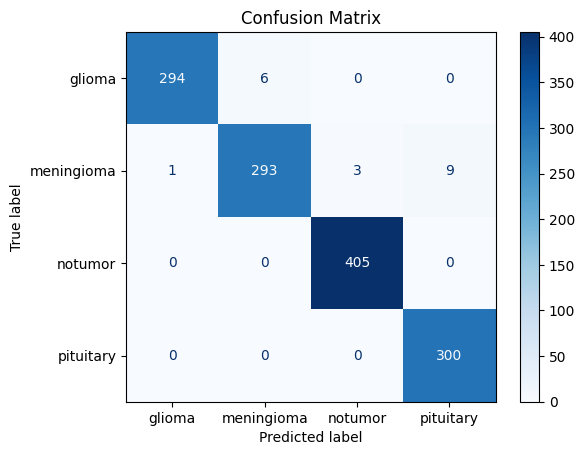

Epoch [1/40], Loss: 0.0218, Validation Accuracy: 98.55%


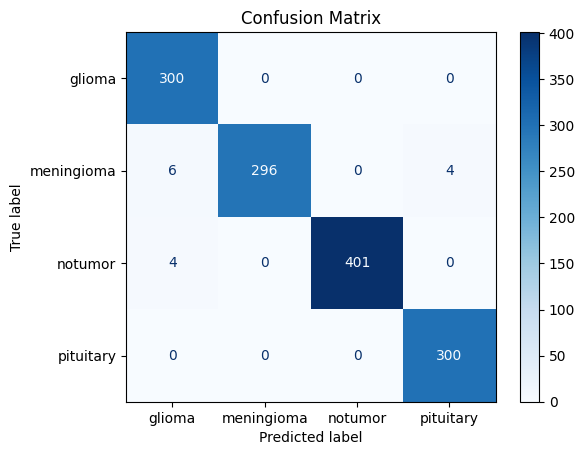

Epoch [2/40], Loss: 0.0313, Validation Accuracy: 98.93%


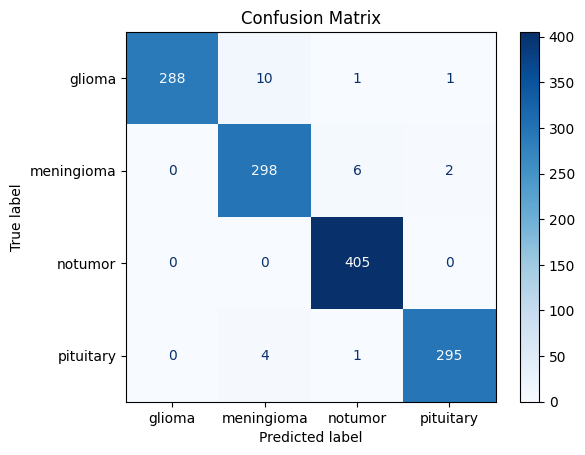

Epoch [3/40], Loss: 0.0278, Validation Accuracy: 98.09%


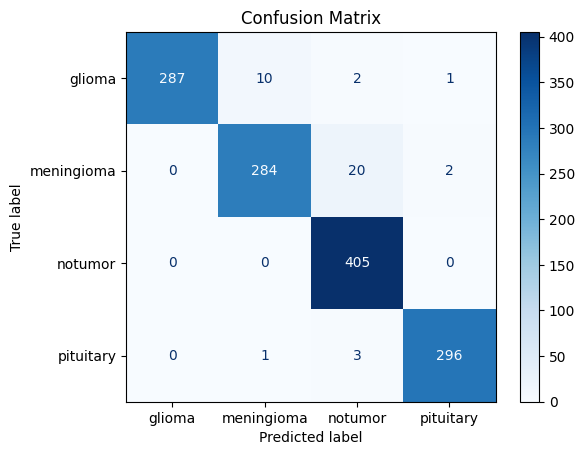

Epoch [4/40], Loss: 0.0266, Validation Accuracy: 97.03%


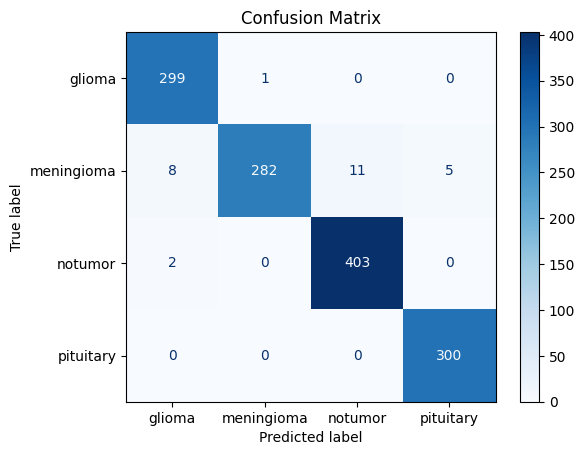

Epoch [5/40], Loss: 0.0385, Validation Accuracy: 97.94%


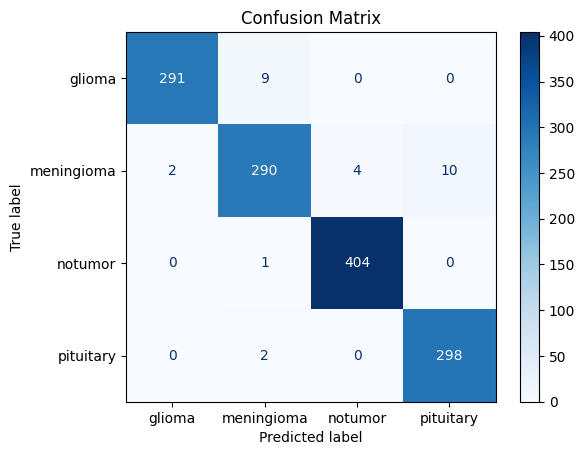

Epoch [6/40], Loss: 0.0520, Validation Accuracy: 97.86%


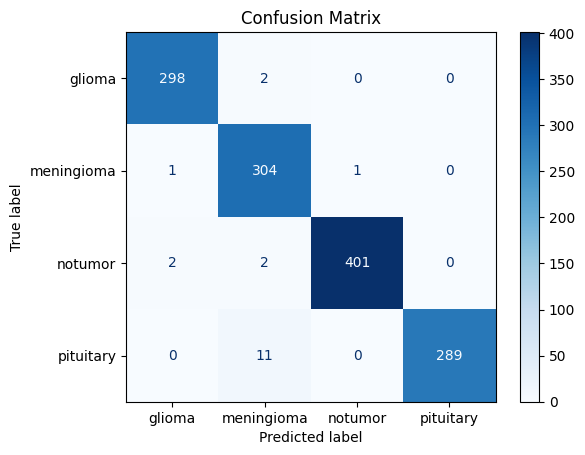

Epoch [7/40], Loss: 0.0250, Validation Accuracy: 98.55%


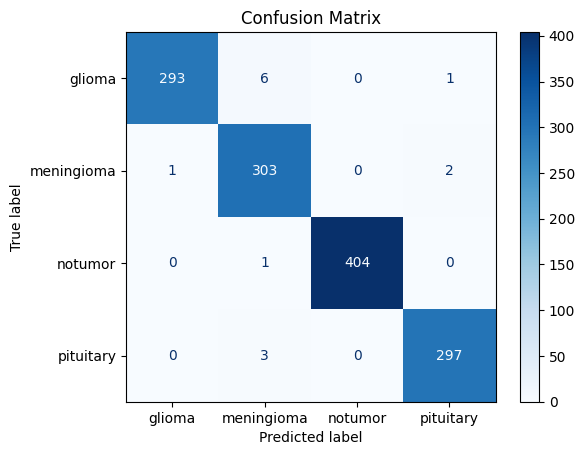

Epoch [8/40], Loss: 0.0490, Validation Accuracy: 98.93%


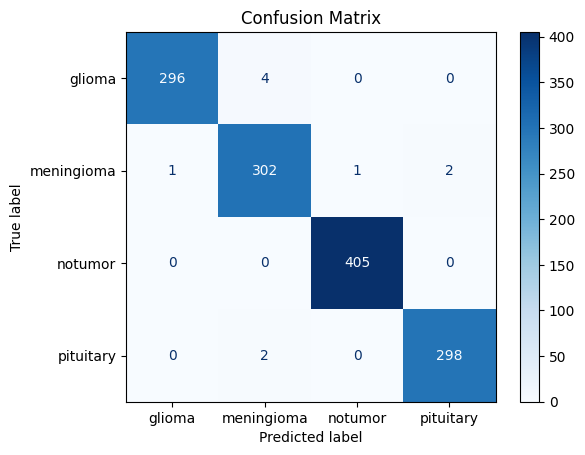

Epoch [9/40], Loss: 0.0180, Validation Accuracy: 99.24%
Target accuracy of 99.0% reached! Stopping training.


In [6]:
# Train the model
# Train the model with the target accuracy of 98%
train_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=40, target_accuracy=99.0
)



# Plot metrics

Test Accuracy: 99.24%
                 precision    recall  f1-score   support

         glioma       1.00      0.99      0.99       300
     meningioma       0.98      0.99      0.98       306
       no_tumor       1.00      1.00      1.00       405
pituitary_tumor       0.99      0.99      0.99       300

       accuracy                           0.99      1311
      macro avg       0.99      0.99      0.99      1311
   weighted avg       0.99      0.99      0.99      1311



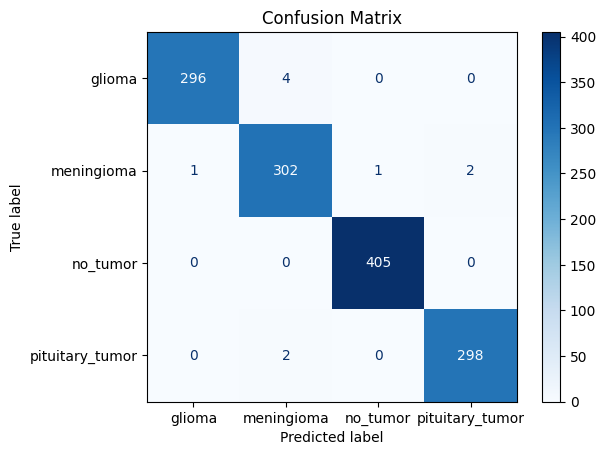

99.2372234935164

In [16]:

# Evaluate the model
evaluate_model(model, test_loader)

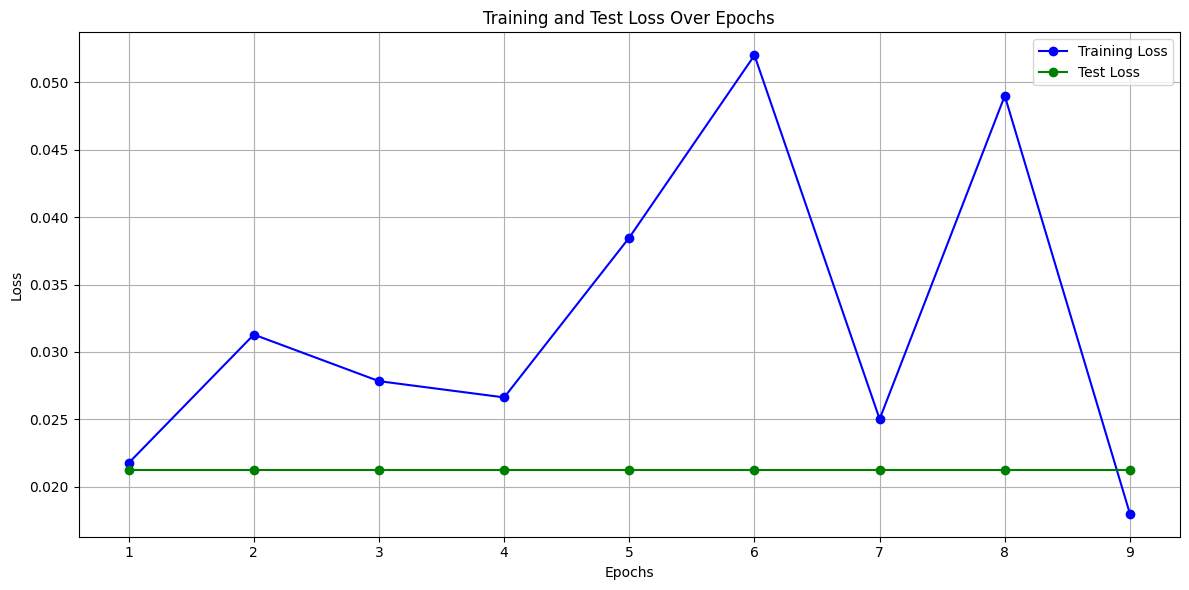

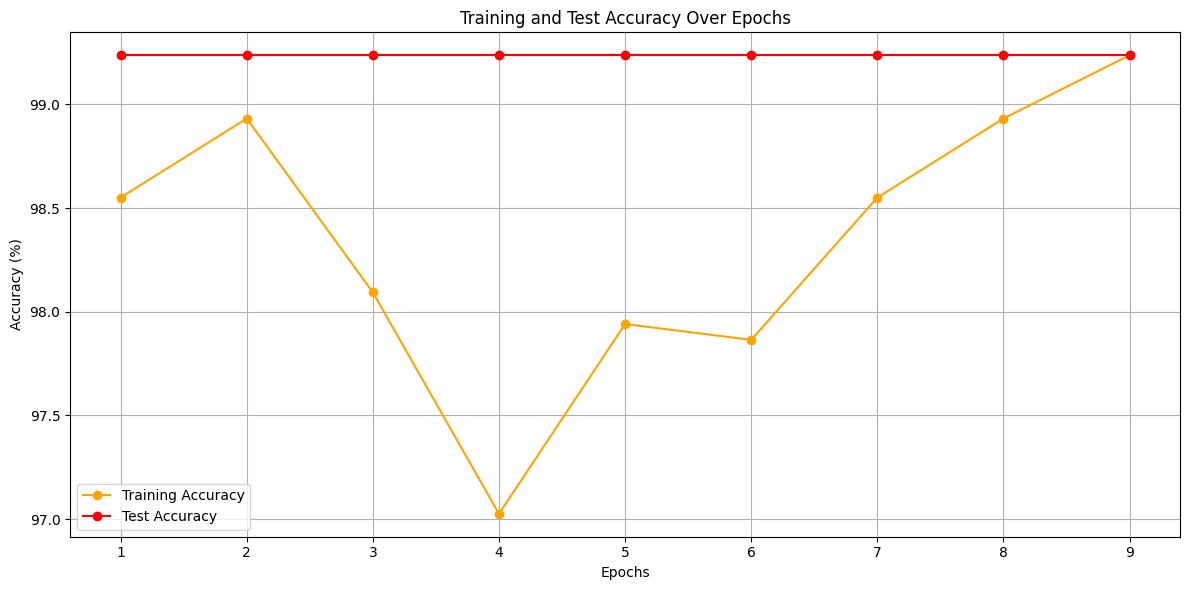

In [40]:
# Function to compute test losses and accuracies
def compute_test_metrics(model, test_loader, criterion):
    model.eval()
    test_losses = []
    test_accuracies = []
    
    for epoch in range(len(train_losses)):  # Match number of epochs
        correct = 0
        total = 0
        total_loss = 0.0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Compute loss
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(test_loader)
        accuracy = 100 * correct / total
        
        test_losses.append(avg_loss)
        test_accuracies.append(accuracy)
    
    return test_losses, test_accuracies

# Compute test metrics
test_losses, test_accuracies = compute_test_metrics(model, test_loader, criterion)

def plot_metrics(train_losses, val_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)  # Epochs start from 1

    # Plot training and test loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot training and test accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, val_accuracies, label='Training Accuracy', marker='o', color='orange')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(train_losses, val_accuracies, test_losses, test_accuracies)


In [43]:
import time

def test_inference_time(model, test_loader):
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
    
    end_time = time.time()
    avg_time = (end_time - start_time) / len(test_loader)
    print(f"Average inference time per batch: {avg_time:.4f} seconds")

# Example usage
test_inference_time(model, test_loader)


Average inference time per batch: 0.1439 seconds


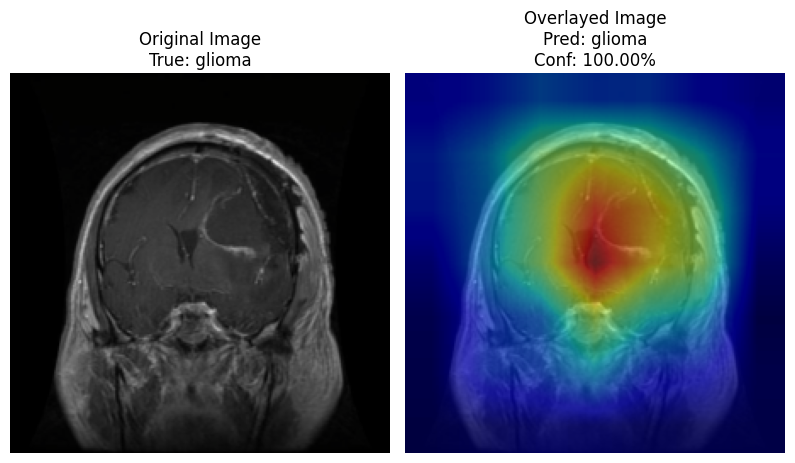

Grad-CAM visualization saved as: /kaggle/working/glioma_gradcam_6.png


In [93]:
from torchvision.transforms.functional import resize
from PIL import Image
import random
import os

def visualize_and_save_gradcam_with_details(model, dataset, target_layer_name, class_names, save_dir="/kaggle/working/"):
    model.eval()

    # Randomly select an image from the dataset
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]

    # Locate the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    grad_cam = GradCAM(model, target_layer)

    # Prepare the input image
    input_tensor = image.unsqueeze(0).to(device)

    # Generate CAM
    cam = grad_cam.generate_cam(input_tensor)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        confidence = torch.softmax(output, dim=1)[0, predicted].item() * 100  # Confidence score

    # De-normalize the image for visualization
    image_for_plot = image.permute(1, 2, 0).detach().numpy()
    image_for_plot = image_for_plot * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_for_plot = np.clip(image_for_plot, 0, 1)

    # Resize the CAM to the same size as the image
    cam_resized = resize(Image.fromarray((cam * 255).astype(np.uint8)), size=(224, 224))  # Resize CAM
    cam_resized = np.array(cam_resized) / 255.0  # Normalize back to [0, 1]

    # Overlay CAM on the original image
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # Convert to jet colormap
    overlayed_image = heatmap * 0.5 + image_for_plot * 0.5  # Blend the heatmap with the image

    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Generate a unique filename
    class_name = class_names[label]
    counter = 1
    file_name = f"{class_name}_gradcam_{counter}.png"
    save_path = os.path.join(save_dir, file_name)

    # Increment the counter if the file already exists
    while os.path.exists(save_path):
        counter += 1
        file_name = f"{class_name}_gradcam_{counter}.png"
        save_path = os.path.join(save_dir, file_name)

    # Save the visualization
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_for_plot)
    plt.title(f"Original Image\nTrue: {class_name}")
    plt.axis('off')


    # Overlayed image
    plt.subplot(1, 3, 2)
    plt.imshow(overlayed_image)
    plt.title(f"Overlayed Image\nPred: {class_names[predicted.item()]}\nConf: {confidence:.2f}%")
    plt.axis('off')

    plt.tight_layout()

    # Save the visualization and show it
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Grad-CAM visualization saved as: {save_path}")


# Example usage
target_layer_name = 'features.denseblock4'  # Use the name of the last convolutional layer
visualize_and_save_gradcam_with_details(model, test_dataset, target_layer_name, class_names)


# Model Architecture 

In [17]:
from collections import Counter

# Count layers
layer_count = Counter([type(layer).__name__ for layer in model.modules()])

# Print layer counts
for layer, count in layer_count.items():
    print(f"{layer}: {count}")



import pandas as pd

# Define the layer counts for each block
layer_distribution = {
    "Block": [
        "Initial Convolution",
        "Dense Block 1",
        "Transition 1",
        "Dense Block 2",
        "Transition 2",
        "Dense Block 3",
        "Transition 3",
        "Dense Block 4",
        "Classification Head",
    ],
    "Conv2d": [1, 6, 1, 12, 1, 48, 1, 32, 0],
    "BatchNorm2d": [1, 6, 1, 12, 1, 48, 1, 32, 0],
    "ReLU": [1, 6, 1, 12, 1, 48, 1, 32, 0],
    "Dense Layers": [0, 6, 0, 12, 0, 48, 0, 32, 0],
    "Pooling": ["MaxPool2d: 1", "0", "AvgPool2d: 1", "0", "AvgPool2d: 1", "0", "AvgPool2d: 1", "0", "0"],
    "Linear": [0, 0, 0, 0, 0, 0, 0, 0, 1],
}

# Convert to a DataFrame
df = pd.DataFrame(layer_distribution)

# Display the table
print(df)

# Optionally, save it to a CSV file
df.to_csv("densenet_layer_distribution.csv", index=False)



# Load the DenseNet201 model
from torchvision import models

# Your pre-trained DenseNet201 model
model = models.densenet201(pretrained=True)

# Check model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")




DenseNet: 1
Sequential: 1
Conv2d: 200
BatchNorm2d: 201
ReLU: 200
MaxPool2d: 1
_DenseBlock: 4
_DenseLayer: 98
_Transition: 3
AvgPool2d: 3
Linear: 1
                 Block  Conv2d  BatchNorm2d  ReLU  Dense Layers       Pooling  \
0  Initial Convolution       1            1     1             0  MaxPool2d: 1   
1        Dense Block 1       6            6     6             6             0   
2         Transition 1       1            1     1             0  AvgPool2d: 1   
3        Dense Block 2      12           12    12            12             0   
4         Transition 2       1            1     1             0  AvgPool2d: 1   
5        Dense Block 3      48           48    48            48             0   
6         Transition 3       1            1     1             0  AvgPool2d: 1   
7        Dense Block 4      32           32    32            32             0   
8  Classification Head       0            0     0             0             0   

   Linear  
0       0  
1       0  
2     

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 20013928
Trainable Parameters: 20013928
Non-Trainable Parameters: 0


# Save the model

In [9]:

save_path = '/kaggle/working/densenet201_brain_tumor.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /kaggle/working/densenet201_brain_tumor.pth


# Test the Model

In [84]:

test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
model_path = '/kaggle/working/densenet201_brain_tumor.pth'

/tmp/ipykernel_30/1638970844.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Grid image saved to: /kaggle/working/predictions_grid5.png


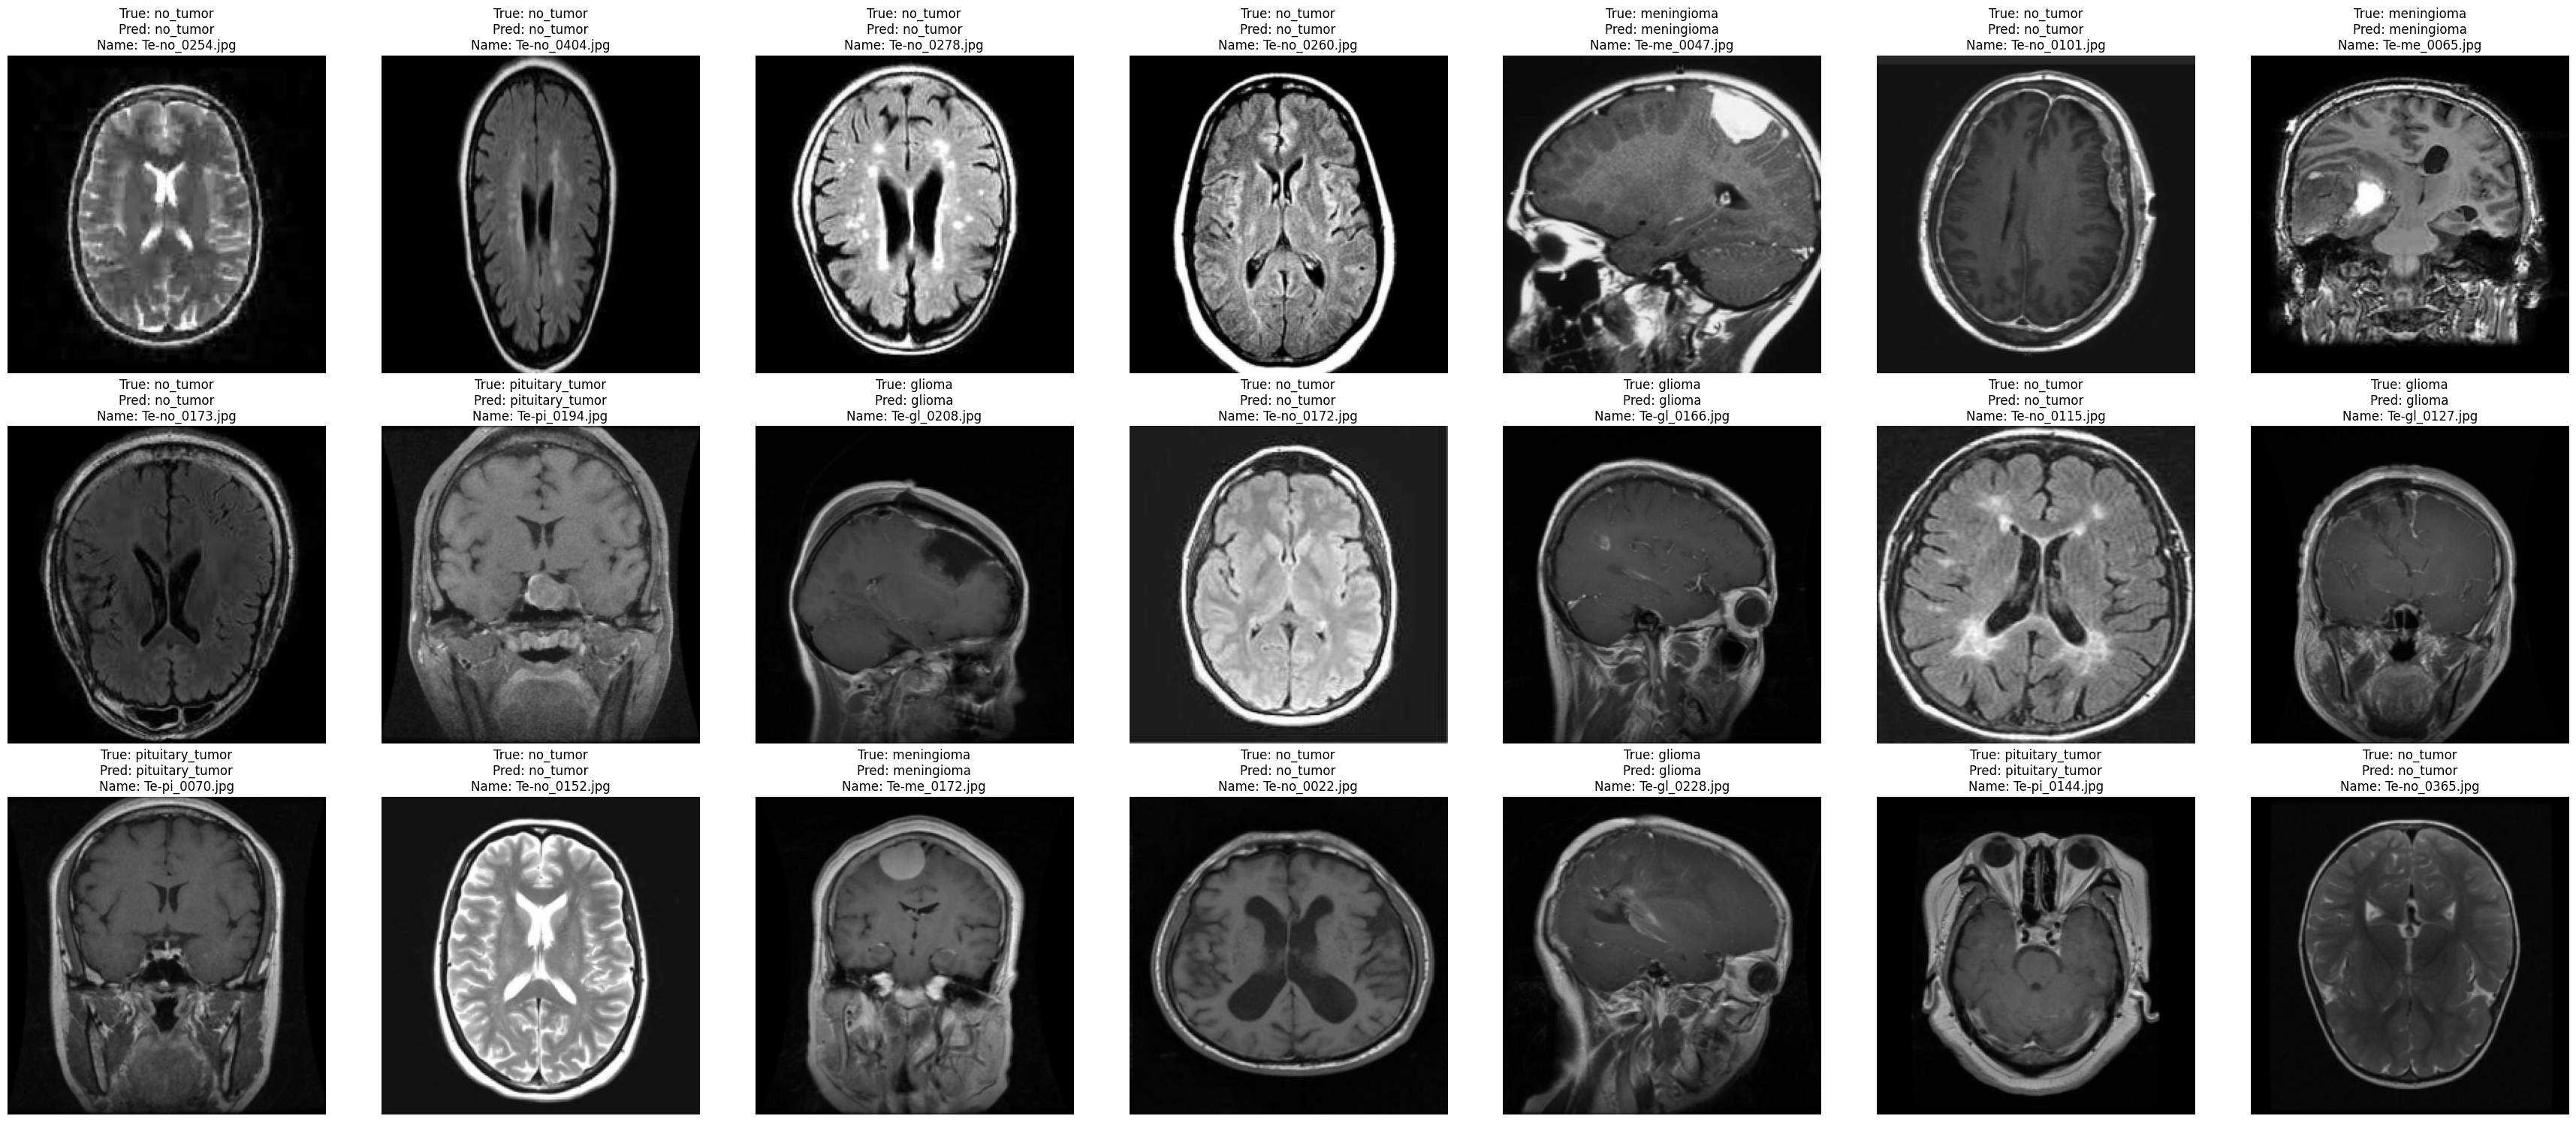

In [86]:
model = models.densenet201(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(class_names))  # Update for 4 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()



# Function to visualize predictions
def test_random_images(model, dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image_for_plot = image.permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        image_for_plot = image_for_plot * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))  # Add batch dimension and send to device
            _, predicted = torch.max(output, 1)
        
        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_for_plot)
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



# Function to visualize predictions with grid layout and save the output image
def test_random_images_grid(model, dataset, num_images=20, images_per_row=6, save_path=None):
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows
    plt.figure(figsize=(images_per_row * 5, num_rows * 5))  # Adjust figure size based on rows and columns
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)  # Randomly select an image
        image, label = dataset[idx]
        image_for_plot = image.permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        image_for_plot = image_for_plot * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
        
        # Get the image filename
        image_path = dataset.samples[idx][0]
        image_name = os.path.basename(image_path)
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))  # Add batch dimension and send to device
            _, predicted = torch.max(output, 1)
        
        # Plot the image
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image_for_plot)
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}\nName: {image_name}")
        plt.axis('off')
    
    plt.tight_layout()
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Grid image saved to: {save_path}")
    
    plt.show()

# Example usage: Save the output image
output_path = "/kaggle/working/predictions_grid5.png"  # Path to save the image
test_random_images_grid(model, test_dataset, num_images=21, images_per_row=7, save_path=output_path)


In [33]:
import os

def delete_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")

# Example usage: Deleting a specific file
file_to_delete = "/kaggle/working/predictions_grid.png"  # Path to the file you want to delete
delete_file(file_to_delete)


File deleted: /kaggle/working/predictions_grid.png


# new approach test

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


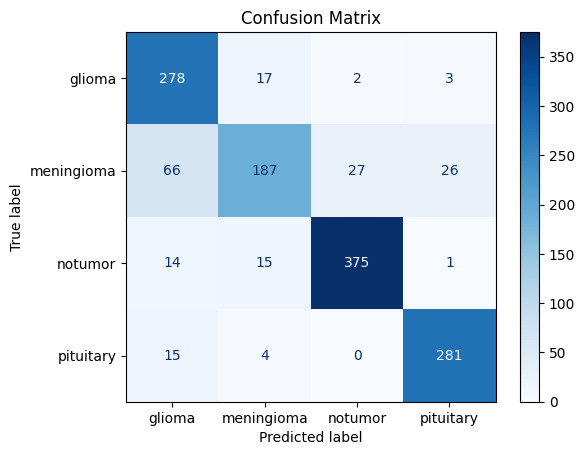

Epoch [1/20], Loss: 0.5422, Validation Accuracy: 85.51%


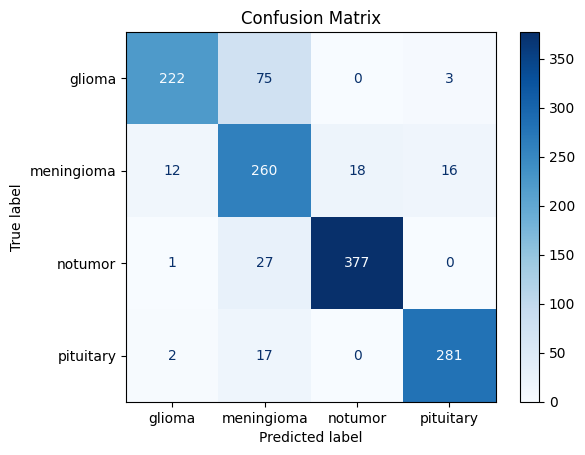

Epoch [2/20], Loss: 0.3660, Validation Accuracy: 86.96%


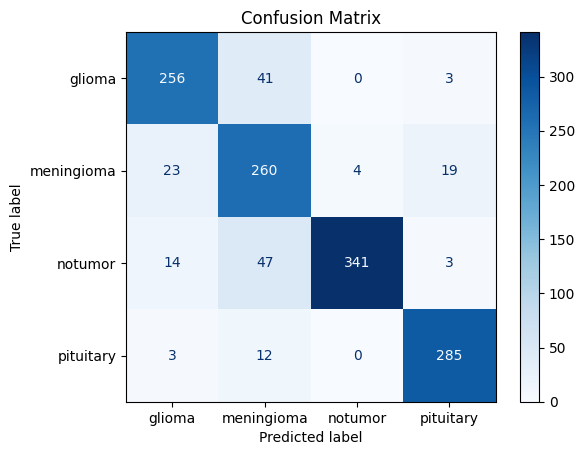

Epoch [3/20], Loss: 0.3478, Validation Accuracy: 87.11%


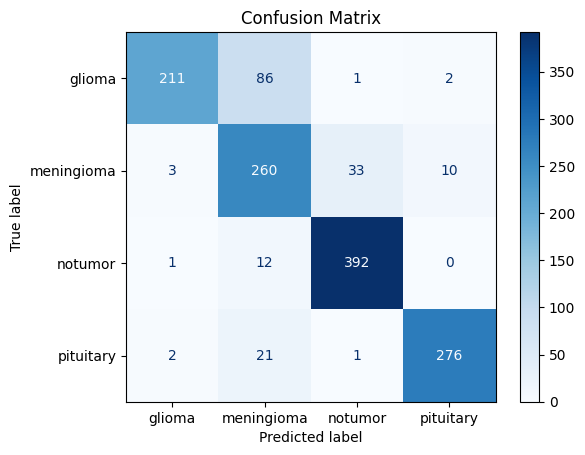

Epoch [4/20], Loss: 0.3387, Validation Accuracy: 86.88%


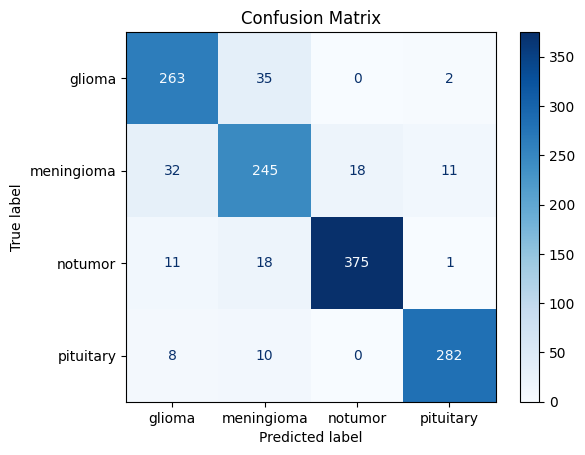

Epoch [5/20], Loss: 0.3157, Validation Accuracy: 88.86%


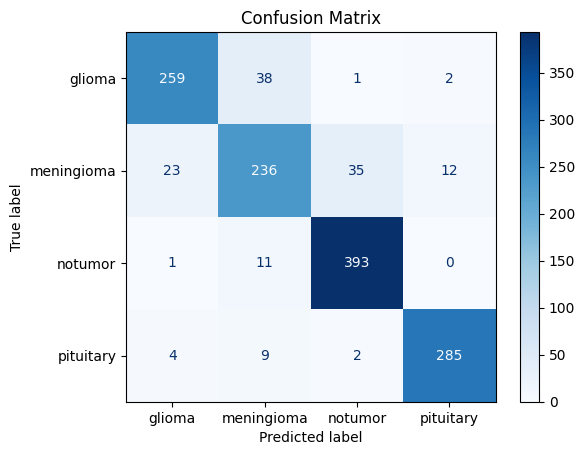

Epoch [6/20], Loss: 0.3030, Validation Accuracy: 89.47%


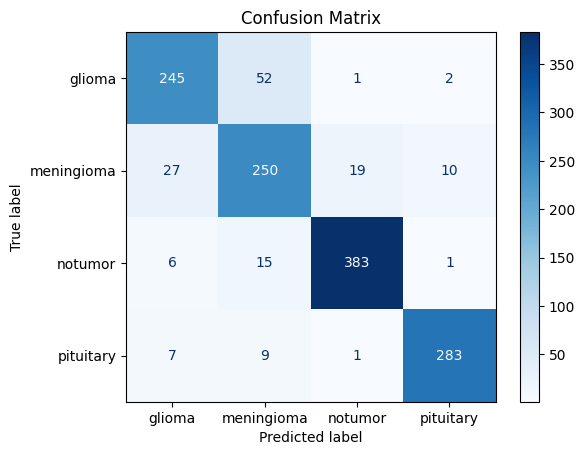

Epoch [7/20], Loss: 0.2981, Validation Accuracy: 88.56%


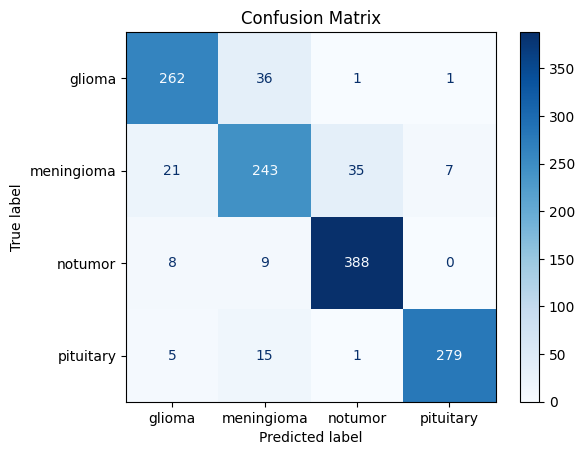

Epoch [8/20], Loss: 0.2733, Validation Accuracy: 89.40%


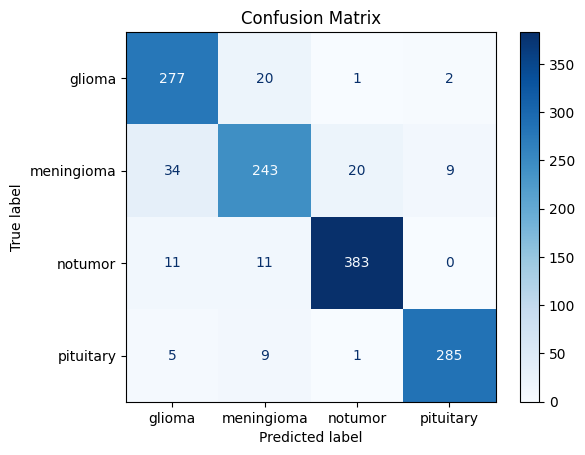

Epoch [9/20], Loss: 0.2714, Validation Accuracy: 90.62%


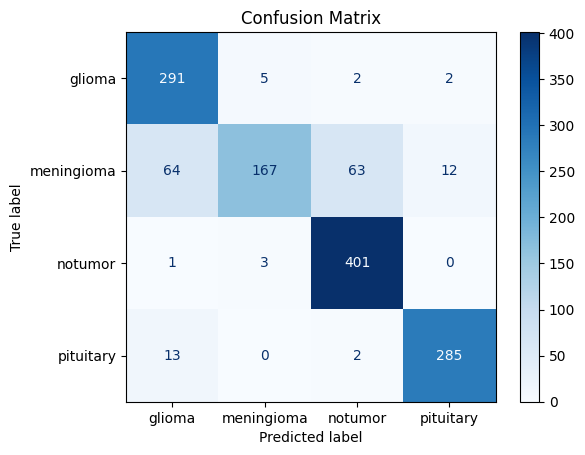

Epoch [10/20], Loss: 0.2725, Validation Accuracy: 87.26%


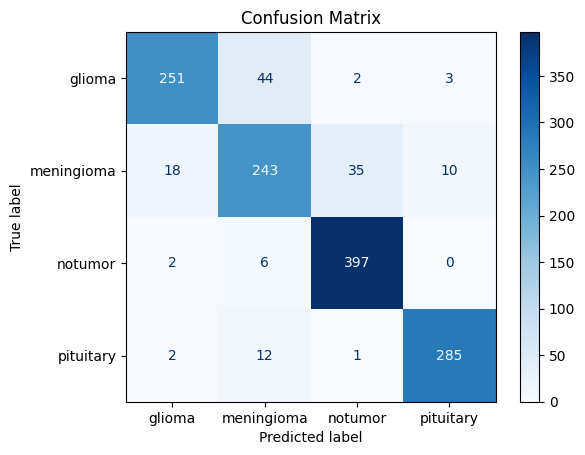

Epoch [11/20], Loss: 0.2577, Validation Accuracy: 89.70%


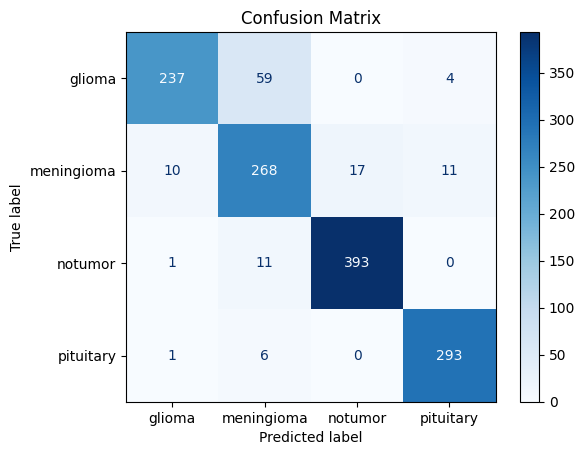

Epoch [12/20], Loss: 0.2508, Validation Accuracy: 90.85%


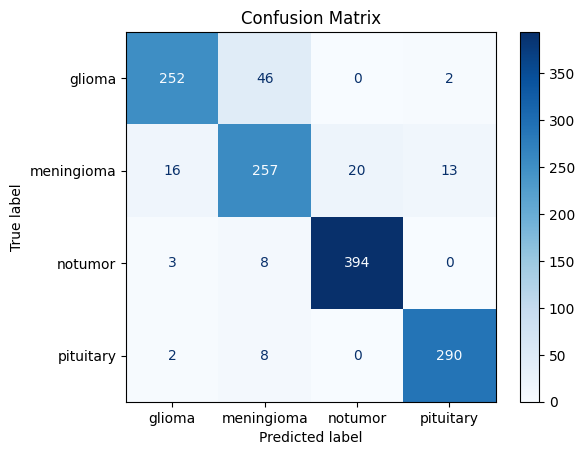

Epoch [13/20], Loss: 0.2518, Validation Accuracy: 91.00%


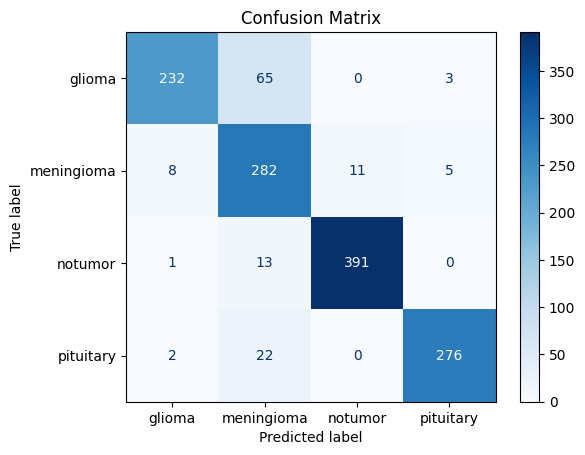

Epoch [14/20], Loss: 0.2357, Validation Accuracy: 90.08%


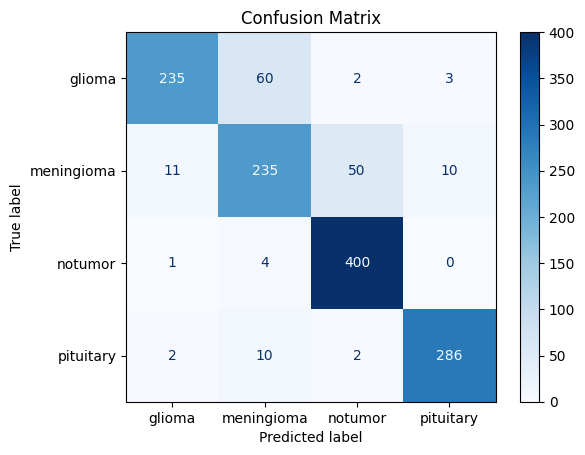

Epoch [15/20], Loss: 0.2482, Validation Accuracy: 88.18%


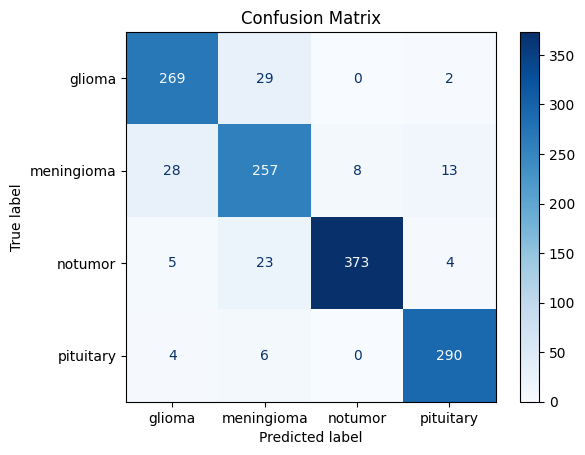

Epoch [16/20], Loss: 0.2382, Validation Accuracy: 90.69%


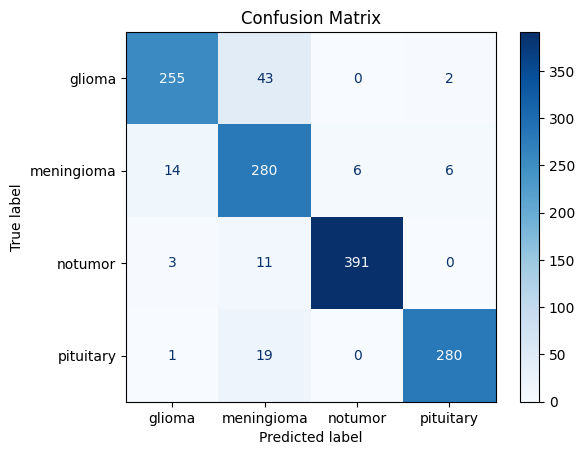

Epoch [17/20], Loss: 0.2489, Validation Accuracy: 91.99%


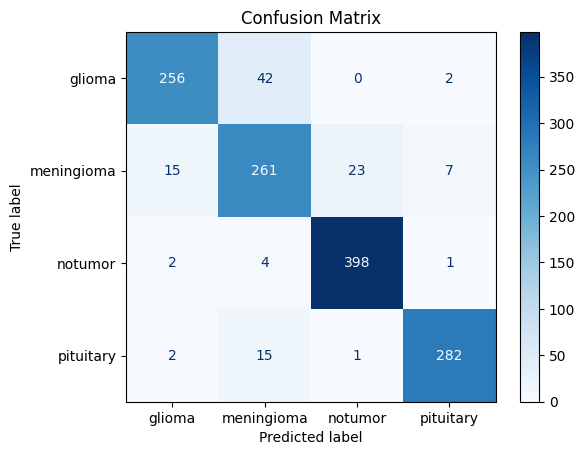

Epoch [20/20], Loss: 0.2355, Validation Accuracy: 91.30%


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os

# Paths for dataset
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Dual feature extractor model
class DualFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(DualFeatureExtractor, self).__init__()
        
        # Load DenseNet-201
        self.densenet = models.densenet201(pretrained=True)
        for param in self.densenet.parameters():
            param.requires_grad = False  # Freeze DenseNet-201 parameters
        self.densenet_features = nn.Sequential(*list(self.densenet.children())[:-1])  # Remove the classifier
        self.densenet_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to 1x1 spatial dimensions
        
        # Load ResNet-50
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze ResNet-50 parameters
        self.resnet_features = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove the classifier
        self.resnet_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to 1x1 spatial dimensions
        
        # Define the new classifier
        densenet_output_size = 1920  # From DenseNet
        resnet_output_size = 2048  # From ResNet
        combined_feature_size = densenet_output_size + resnet_output_size
        
        self.fc = nn.Sequential(
            nn.Linear(combined_feature_size, 512),  # Combine DenseNet-201 and ResNet-50 features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer for classification
        )
        
    def forward(self, x):
        # Extract features using DenseNet-201
        dense_features = self.densenet_features(x)
        dense_features = self.densenet_pool(dense_features)  # Apply adaptive pooling
        dense_features = torch.flatten(dense_features, 1)  # Flatten DenseNet-201 features
        
        # Extract features using ResNet-50
        resnet_features = self.resnet_features(x)
        resnet_features = self.resnet_pool(resnet_features)  # Apply adaptive pooling
        resnet_features = torch.flatten(resnet_features, 1)  # Flatten ResNet-50 features
        
        # Concatenate features
        combined_features = torch.cat((dense_features, resnet_features), dim=1)
        
        # Pass through the classifier
        out = self.fc(combined_features)
        return out


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)  # Number of classes in the dataset
model = DualFeatureExtractor(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10, target_accuracy=99.0):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_accuracy = evaluate_model(model, test_loader, log=False)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        if val_accuracy >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached! Stopping training.")
            break
    
    return train_losses, val_accuracies

# Function to evaluate the model
def evaluate_model(model, test_loader, log=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    if log:
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy

# Train the model
train_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=20, target_accuracy=99.0
)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-dat

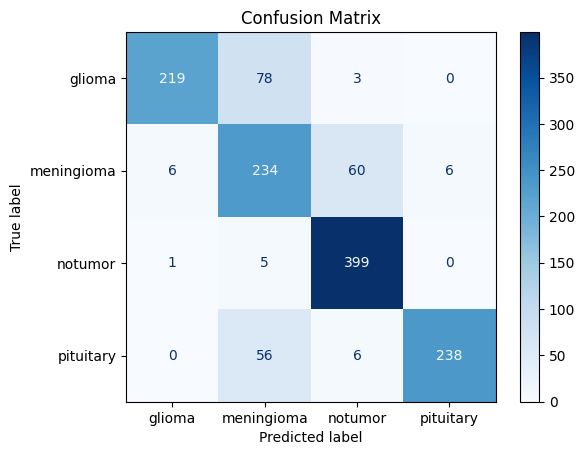

Epoch [1/40], Loss: 0.5077, Validation Accuracy: 83.14%


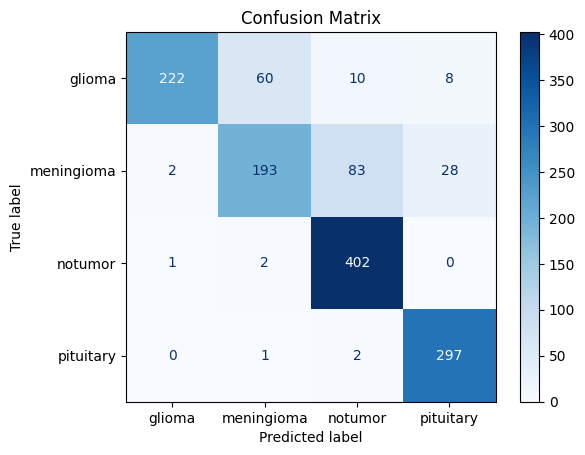

Epoch [2/40], Loss: 0.3464, Validation Accuracy: 84.97%


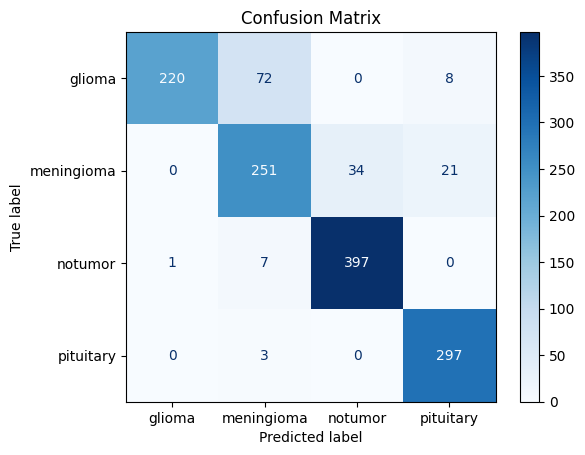

Epoch [3/40], Loss: 0.2872, Validation Accuracy: 88.86%


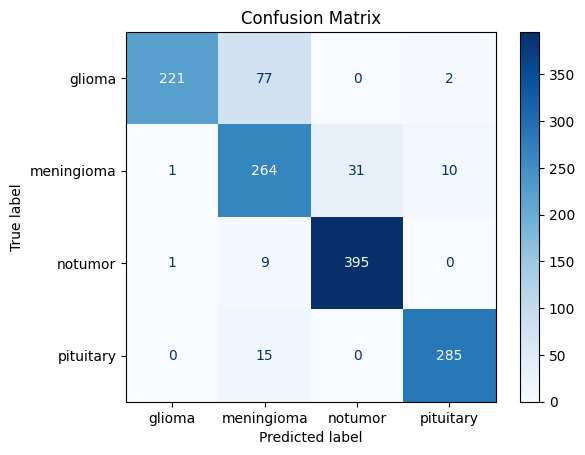

Epoch [4/40], Loss: 0.2851, Validation Accuracy: 88.86%


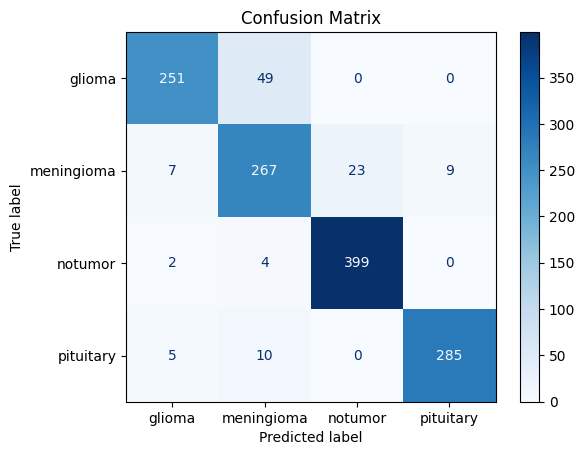

Epoch [5/40], Loss: 0.2707, Validation Accuracy: 91.69%


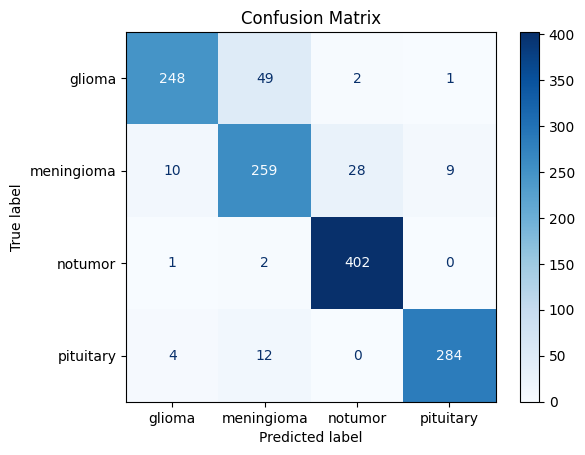

Epoch [6/40], Loss: 0.2398, Validation Accuracy: 91.00%


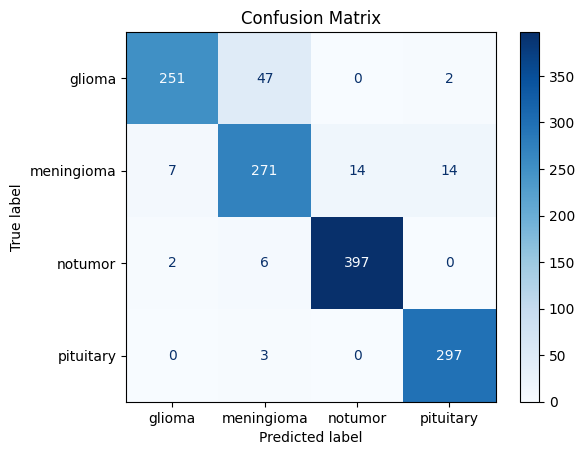

Epoch [7/40], Loss: 0.2398, Validation Accuracy: 92.75%


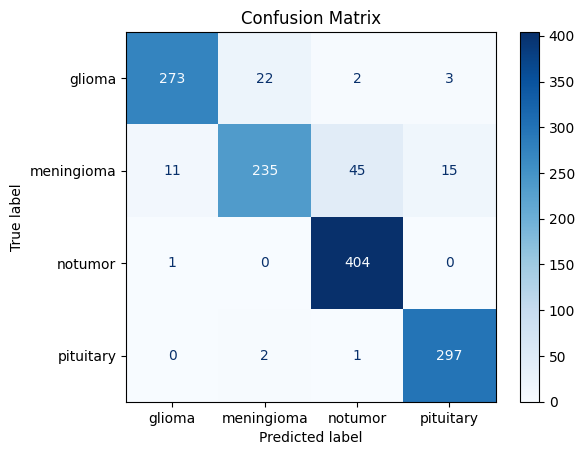

Epoch [8/40], Loss: 0.2234, Validation Accuracy: 92.22%


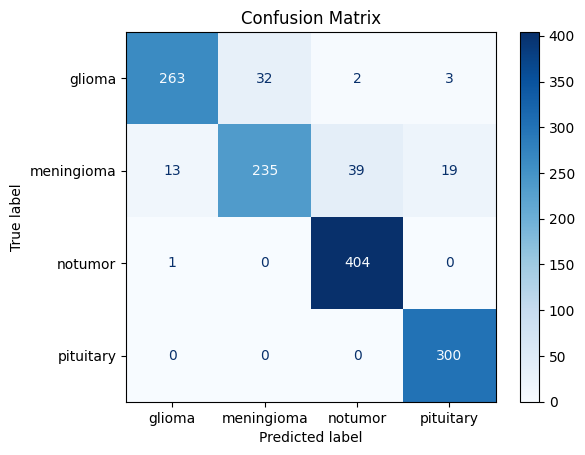

Epoch [9/40], Loss: 0.2278, Validation Accuracy: 91.69%


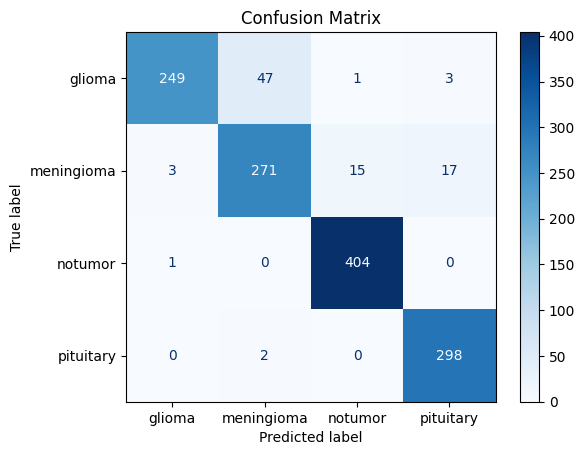

Epoch [10/40], Loss: 0.2156, Validation Accuracy: 93.21%


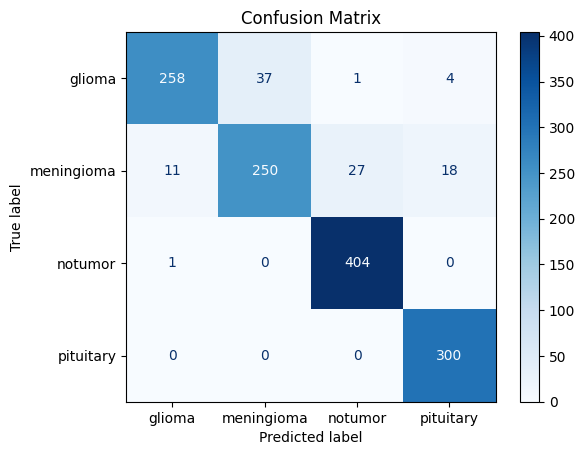

Epoch [11/40], Loss: 0.2120, Validation Accuracy: 92.45%


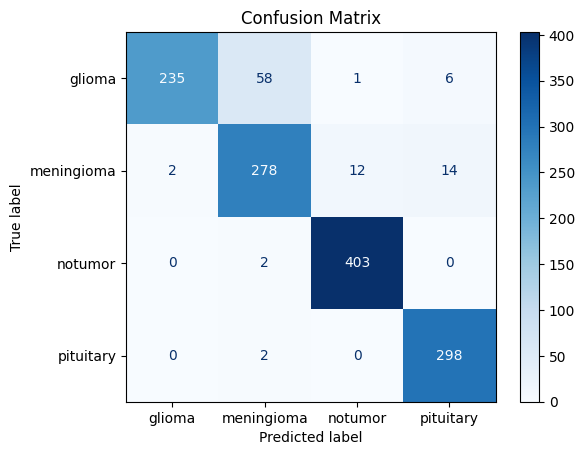

Epoch [12/40], Loss: 0.2065, Validation Accuracy: 92.60%


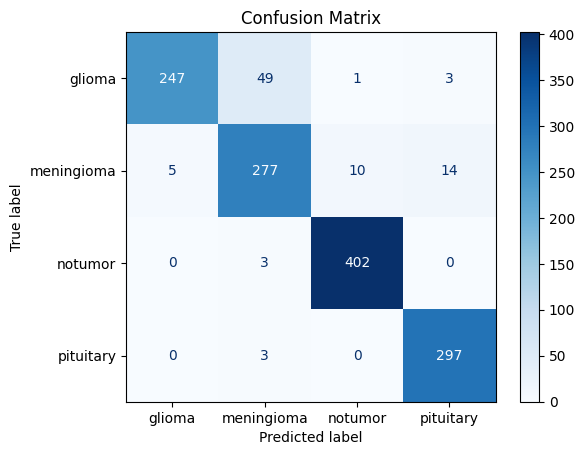

Epoch [13/40], Loss: 0.2004, Validation Accuracy: 93.29%


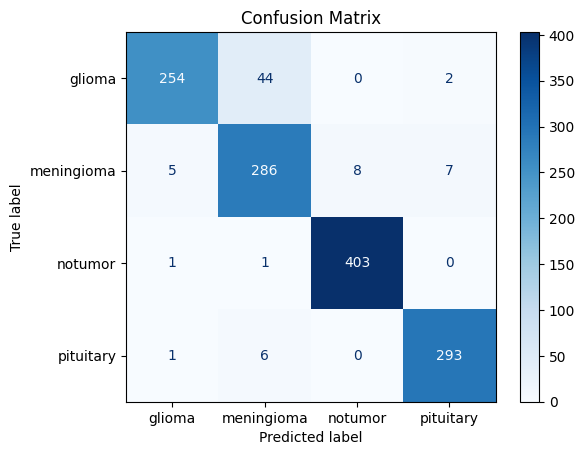

Epoch [14/40], Loss: 0.1972, Validation Accuracy: 94.28%


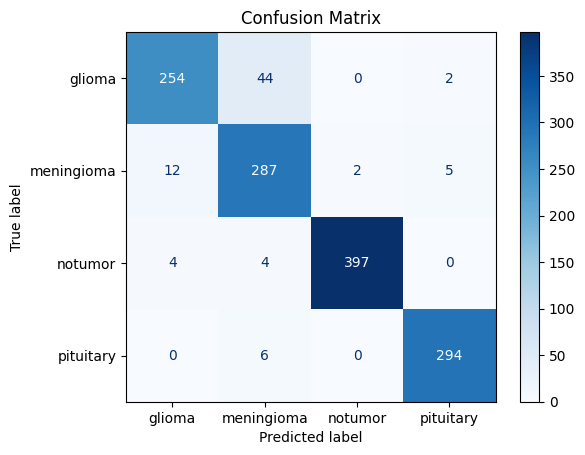

Epoch [15/40], Loss: 0.1838, Validation Accuracy: 93.97%


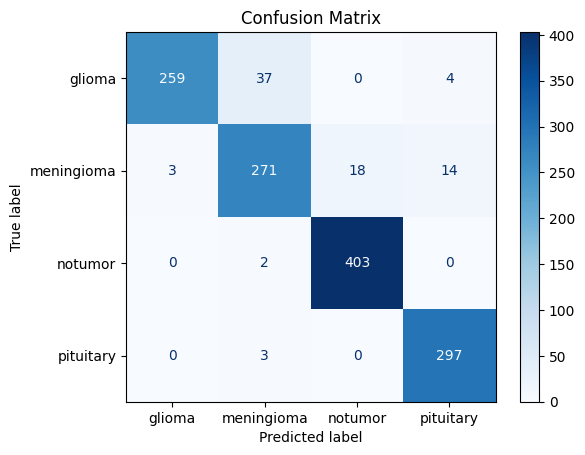

Epoch [16/40], Loss: 0.1815, Validation Accuracy: 93.82%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Paths for dataset
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


# Triple feature extractor model
class TripleFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(TripleFeatureExtractor, self).__init__()
        
        # Load DenseNet-201
        self.densenet = models.densenet201(pretrained=True)
        for param in self.densenet.parameters():
            param.requires_grad = False
        self.densenet_features = nn.Sequential(*list(self.densenet.children())[:-1])
        self.densenet_pool = nn.AdaptiveAvgPool2d((1, 1))  # Fixed feature map size
        
        # Load ResNet-50
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet_features = nn.Sequential(*list(self.resnet.children())[:-2])
        self.resnet_pool = nn.AdaptiveAvgPool2d((1, 1))  # Fixed feature map size
        
        # Load EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        self.efficientnet_features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        self.efficientnet_pool = nn.AdaptiveAvgPool2d((1, 1))  # Fixed feature map size
        
        # Combined feature sizes
        densenet_output_size = 1920
        resnet_output_size = 2048
        efficientnet_output_size = 1280
        combined_feature_size = densenet_output_size + resnet_output_size + efficientnet_output_size
        
        # New classifier
        self.fc = nn.Sequential(
            nn.Linear(combined_feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # DenseNet features
        dense_features = self.densenet_features(x)
        dense_features = self.densenet_pool(dense_features)
        dense_features = torch.flatten(dense_features, 1)
        
        # ResNet features
        resnet_features = self.resnet_features(x)
        resnet_features = self.resnet_pool(resnet_features)
        resnet_features = torch.flatten(resnet_features, 1)
        
        # EfficientNet features
        efficientnet_features = self.efficientnet_features(x)
        efficientnet_features = self.efficientnet_pool(efficientnet_features)
        efficientnet_features = torch.flatten(efficientnet_features, 1)
        
        # Combine features
        combined_features = torch.cat((dense_features, resnet_features, efficientnet_features), dim=1)
        
        # Classifier
        out = self.fc(combined_features)
        return out


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
model = TripleFeatureExtractor(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


# Function to train the model
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=40, target_accuracy=99.0):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_accuracy = evaluate_model(model, test_loader, log=False)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        if val_accuracy >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached! Stopping training.")
            break
    
    return train_losses, val_accuracies


# Function to evaluate the model
def evaluate_model(model, test_loader, log=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    if log:
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy


# Train the model
train_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=40, target_accuracy=99.0
)
